# Thêm thư viện cần thiết


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.4 MB/s 
     |████████████████████████████████| 9.8 MB 40.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [6]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')


# Nạp dữ liệu


In [7]:
train_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/7_3/eth/ethereum_train_7_3.csv", parse_dates=True, index_col=0)
train_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,0.23180,0.24981,0.23085,0.24797,11970598,USD
2020-06-02,0.24801,0.25321,0.22795,0.23794,12686011,USD
2020-06-03,0.23790,0.24476,0.23384,0.24452,8151002,USD
2020-06-04,0.24453,0.24641,0.23668,0.24337,8749785,USD
2020-06-05,0.24337,0.24750,0.23970,0.24023,7754761,USD


In [8]:
train = train_ETH[["Open"]]
train.head(5)

,Open
Date,
2020-06-01,0.23180
2020-06-02,0.24801
2020-06-03,0.23790
2020-06-04,0.24453
2020-06-05,0.24337


In [9]:
test_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/7_3/eth/ethereum_test_7_3.csv", parse_dates=True, index_col=0)
test_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2021-10-26,4.21992,4.29198,4.09819,4.12951,559294,USD
2021-10-27,4.13006,4.29961,3.91406,3.92193,1068620,USD
2021-10-28,3.92154,4.28980,3.89633,4.28490,865802,USD
2021-10-29,4.28490,4.45830,4.26821,4.41370,781573,USD
2021-10-30,4.41370,4.42841,4.25024,4.32065,494872,USD


In [10]:
test = test_ETH[["Open"]]
test.head(5)

,Open
Date,
2021-10-26,4.21992
2021-10-27,4.13006
2021-10-28,3.92154
2021-10-29,4.28490
2021-10-30,4.41370


In [11]:
df = pd.concat([train.reset_index(level=0), test.reset_index(level=0)],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.index=df.Date
df.drop("Date", axis=1, inplace=True)
df.head(5)    

,Open
Date,
2020-06-01,0.23180
2020-06-02,0.24801
2020-06-03,0.23790
2020-06-04,0.24453
2020-06-05,0.24337


# Vẽ đồ thị

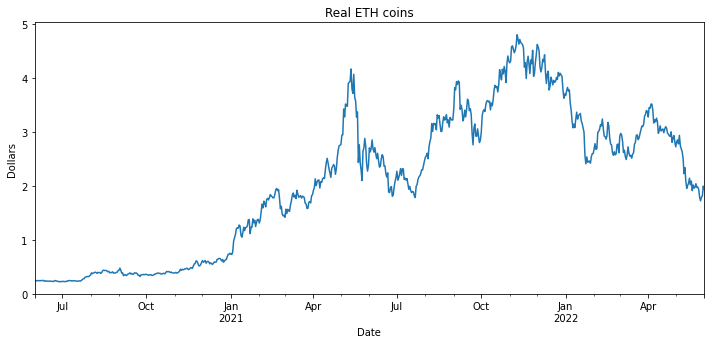

In [13]:
# Thư viện vẽ đồ thị
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real ETH coins'
ylabel='Dollars'
xlabel='Date' 

ax = df['Open'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Kiểm tra tính dừng của chuỗi

In [ ]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")


In [ ]:
adf_test(df['Open'], 'Bitcoin Price')


Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.628066
p-value                     0.468503
Number of lags used         6.000000
Number of observations    724.000000
critical value (1%)        -3.439414
critical value (5%)        -2.865540
critical value (10%)       -2.568900
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


##### Nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng


# Lấy sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng


In [ ]:
df['diff1'] = df['Open'].diff()
df.head()


,Open,diff1
Date,,
2020-06-01,0.23180,NaN
2020-06-02,0.24801,0.01621
2020-06-03,0.23790,-0.01011
2020-06-04,0.24453,0.00663
2020-06-05,0.24337,-0.00116


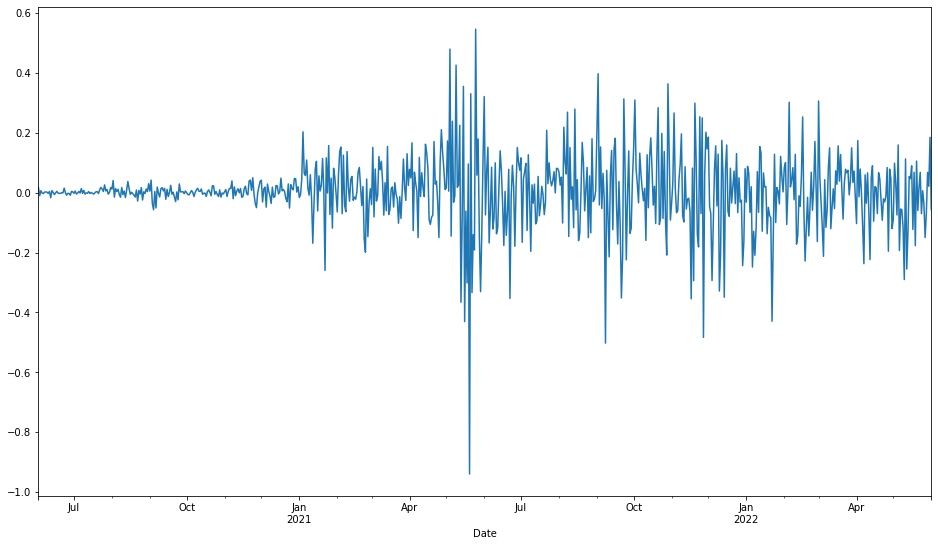

In [ ]:
df['diff1'].dropna().plot(figsize=(16, 9))


# Kiểm định tính dừng của chuỗi tại sai phân bậc 1


In [ ]:
adf_test(df['diff1'], 'Bitcoin Price at First Difference')


Augmented Dickey-Fuller Test: Bitcoin Price at First Difference
ADF test statistic       -1.017531e+01
p-value                   6.917300e-18
Number of lags used       5.000000e+00
Number of observations    7.240000e+02
critical value (1%)      -3.439414e+00
critical value (5%)      -2.865540e+00
critical value (10%)     -2.568900e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


##### Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1


# Thực hiện xây dựng mô hình ARIMA

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [ ]:
df_scaled = df.copy().drop(columns=['diff1'])

scaler = StandardScaler()

df_scaled['Open'] = scaler.fit_transform(df_scaled['Open'].values.reshape(-1, 1))
df_scaled.head()

,Open
Date,
2020-06-01,-1.394670
2020-06-02,-1.382460
2020-06-03,-1.390075
2020-06-04,-1.385081
2020-06-05,-1.385955


## Chia dữ liệu thành tập train và tập test

In [ ]:
interrupt = len(train)
interrupt

512

In [ ]:
index_test = df_scaled.index[interrupt:]
print(train.shape)
print(test.shape)
print(index_test.shape)

(512, 1)
(219, 1)
(219,)


In [ ]:
train.tail()

,Open
Date,
2021-10-21,4.16051
2021-10-22,4.05389
2021-10-23,3.97094
2021-10-24,4.16880
2021-10-25,4.08268


In [ ]:
test.head()

,Open
Date,
2021-10-26,4.21992
2021-10-27,4.13006
2021-10-28,3.92154
2021-10-29,4.28490
2021-10-30,4.41370


## Tìm các hệ số p, q và d phù hợp cho mô hình ARIMA

In [ ]:
warnings.filterwarnings('ignore')


def arima_model(ts_data):
    fit_model = auto_arima(ts_data, test='adf', seasonal=False, trace=True)
    print(fit_model.summary())
    return fit_model


#### Dựa vào chỉ số AIC
- Chỉ số AIC càng thấp thì mô hình càng phù hợp

In [ ]:
fitted = arima_model(train)
fitted.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-781.004, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-776.060, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-781.967, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-781.026, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-775.784, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-781.613, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-784.604, Time=0.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-780.798, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-783.004, Time=1.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-782.015, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-784.020, Time=0.53 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 6.070 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  512
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 396.302
Date:                Sun, 26 Jun 2022   AIC                           -784.604
Time:                        02:26:19   BIC                           -767.659
Sample:                             0   HQIC                          -777.961
                                - 512                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0138      0.009      1.557      0.120      -0.004       0.031
ar.L1         -0.8289      0.070    -11.822      0.000      -0.966      -0.691
ma.L1          0.7407      0.090      8.200      0.000       0.564       0.918
sigma2         0.0124      0.000     38.122      0.000       0.012       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              3097.49
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             126.94   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test


In [ ]:
pred = fitted.predict(len(test))
pred


array([4.10910347, 4.10101259, 4.12152951, 4.11833437, 4.13479337,
       4.13496171, 4.14863283, 4.15111195, 4.16286775, 4.16693442,
       4.17737435, 4.18253169, 4.1920676 , 4.19797426, 4.20688908,
       4.21331054, 4.22179866, 4.2285738 , 4.23676877, 4.24378688,
       4.25178046, 4.25896551, 4.26682071, 4.27412045, 4.2818806 ,
       4.28925913, 4.29695397, 4.30438663, 4.3120366 , 4.31950645,
       4.32712559, 4.33462099, 4.34221896, 4.34973191, 4.35731533,
       4.36484035, 4.37241377, 4.37994707, 4.38751362, 4.39505261,
       4.40261445, 4.41015735, 4.41771595, 4.42526154, 4.43281791,
       4.44036534, 4.44792018, 4.45546888, 4.46302267, 4.47057224,
       4.47812531, 4.48567548, 4.49322805, 4.50077863, 4.50833086,
       4.51588173, 4.52343372, 4.53098478, 4.53853662, 4.54608781,
       4.55363953, 4.56119081, 4.56874246, 4.57629381, 4.58384541,
       4.59139679, 4.59894836, 4.60649977, 4.61405131, 4.62160275,
       4.62915427, 4.63670572, 4.64425723, 4.65180869, 4.65936

# Vẽ đồ thị cho tập test và kết quả dự đoán

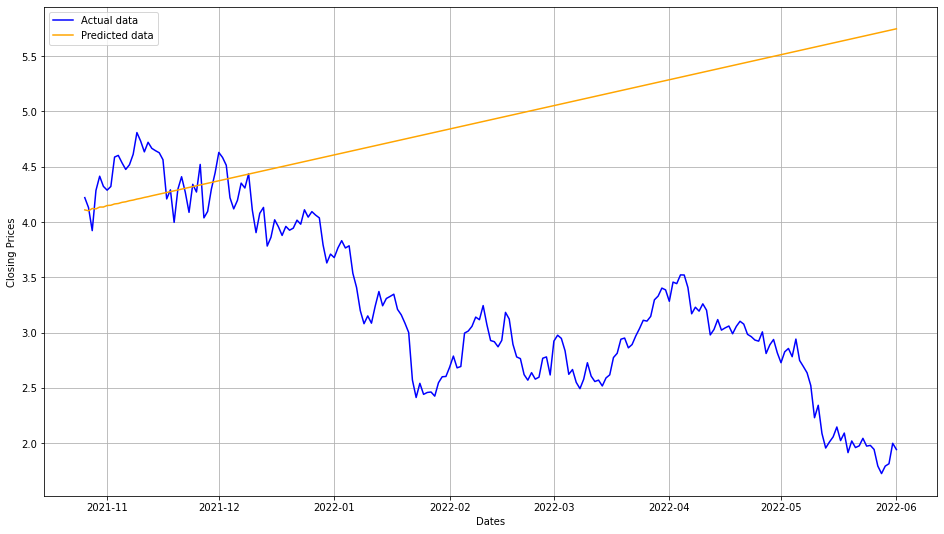

In [ ]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test, 'blue', label='Actual data')
plt.plot(pred_series, 'orange', label='Predicted data')
plt.legend()


# Đưa dữ liệu về miền giá trị ban đầu


In [ ]:
actual = column_or_1d(test)
pred = column_or_1d(pred)

inv_actual = scaler.inverse_transform(actual.reshape(-1, 1))
inv_pred = scaler.inverse_transform(pred.reshape(-1, 1))


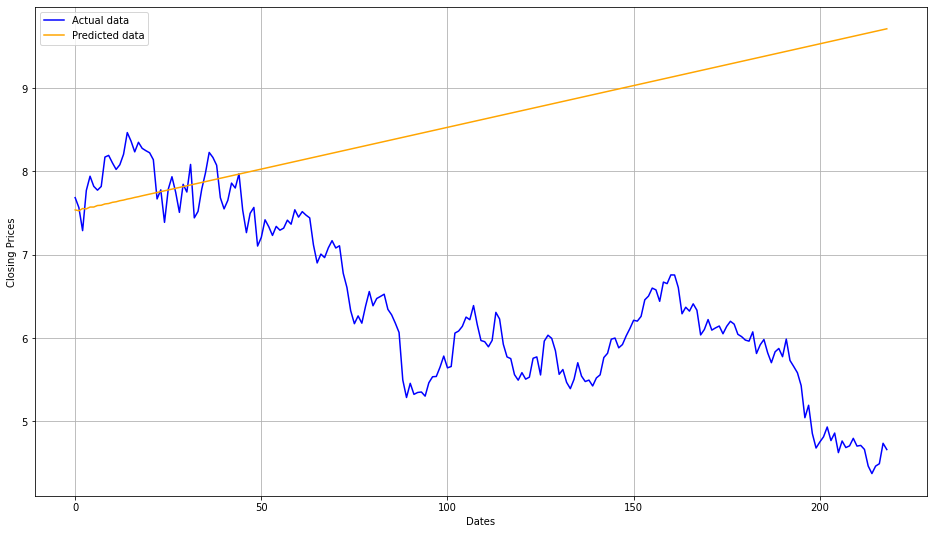

In [ ]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_actual, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình qua các chỉ số MAE, MAPE, MSE, RMSE

In [ ]:
# mae = mean_absolute_error(inv_actual, inv_pred)
mape = mean_absolute_percentage_error(inv_actual, inv_pred)
mse = mean_squared_error(inv_actual, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_actual, inv_pred)

# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


MAPE: 40.71%
RMSE: 2.74
R2: -6.04
